### IMPORT

In [15]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df= pd.read_csv('house_price.csv')
house = house_df.copy()
house.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


### EDA

In [16]:
print(house.shape)
print(house.dtypes.value_counts())

(1460, 81)
object     43
int64      35
float64     3
dtype: int64


In [17]:
isnull = house.isnull().sum()
isnull[isnull>0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

##### target value : SalePrice

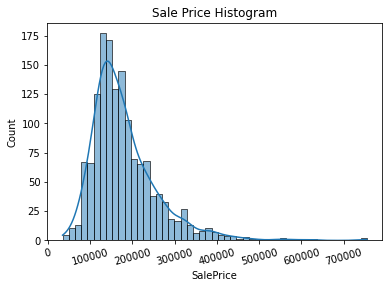

In [6]:
plt.title('Sale Price Histogram')
plt.xticks(rotation = 15)
sns.histplot(house['SalePrice'], kde=True)
plt.show()

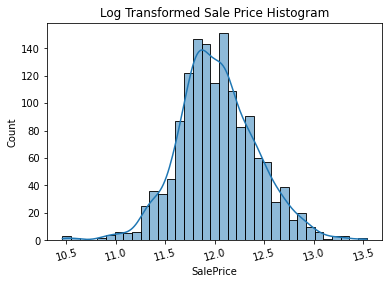

In [7]:
plt.title('Log Transformed Sale Price Histogram')
plt.xticks(rotation = 15)
sns.histplot(np.log1p(house['SalePrice']), kde=True)
plt.show()

### Preprocessing

In [18]:
# target value log transform : 정규화
house['SalePrice'] = np.log1p(house['SalePrice'])

In [20]:
# Null값이 너무 많은 컬럼 : 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'
# 필요 없는 컬럼 : 'Id'
house.drop(columns=['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1, inplace=True)

# 나머지 Null값 있는 숫자형 컬럼들은 평균값으로 대체 
house.fillna(house.mean(), inplace=True)

In [21]:
isnull = house.isnull().sum()
isnull[isnull>0].index

Index(['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond'],
      dtype='object')

In [35]:
s1 = ['a', 'b', np.nan]
pd.get_dummies(s1, dummy_na=False)


,a,b
0,1,0
1,0,1
2,0,0


In [22]:
# one hot encoding
# pd.get_dummies로 원핫인코딩하면 null 레코드들도 자동으로 원핫인코딩된다 (0)으로 
print(house.shape)
house_ohe = pd.get_dummies(house)
print(house_ohe.shape)


(1460, 75)
(1460, 271)


In [36]:
isnull = house_ohe.isnull().sum()
isnull[isnull>0].index
# object variable에 대해서도 null값이 다 없어진 것을 확인할 수 있음!!

Index([], dtype='object')

In [ ]:
house_ohe['SalePrice']

### Model + Evaluation (1)

In [40]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y = house_ohe['SalePrice']
X = house_ohe.drop(columns=['SalePrice'],axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=117)

lr_reg = LinearRegression()
ridge = Ridge()
lasso = Lasso()

lr_reg.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

def get_rmse(model):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return np.round(rmse,3)

for model in [lr_reg, ridge, lasso]:
    print('model:{}, rmsLe:{}'.format(model, get_rmse(model)))

model:LinearRegression(), rmsLe:0.125
model:Ridge(), rmsLe:0.12
model:Lasso(), rmsLe:0.162


In [31]:
# 각 회귀 모델별 top 10, low 10 coefficients 관찰
models = [lr_reg, ridge, lasso]
for model in models:
    coefs = pd.Series(model.coef_, index = X.columns)
    top_10 = coefs.sort_values(ascending=False).head(10)
    low_10 = coefs.sort_values(ascending=False).tail(10)
    print('model:{}, top10:\n {}, \n low10:\n {}'.format(model, top_10, low_10))
    print('###############')

model:LinearRegression(), top10:
 GrLivArea          8.871032e+06
BsmtFinSF1         7.744241e+06
BsmtFinSF2         7.744241e+06
BsmtUnfSF          7.744241e+06
BldgType_2fmCon    1.650031e+05
BldgType_1Fam      1.650031e+05
BldgType_Duplex    1.650030e+05
BldgType_TwnhsE    1.650030e+05
BldgType_Twnhs     1.650030e+05
CentralAir_Y       5.137930e+04
dtype: float64, 
 low10:
 Exterior1st_VinylSd   -1.988012e+04
Exterior1st_HdBoard   -1.988013e+04
Exterior1st_WdShing   -1.988013e+04
Exterior1st_Wd Sdng   -1.988017e+04
Exterior1st_CemntBd   -1.988020e+04
Exterior1st_BrkComm   -1.988057e+04
TotalBsmtSF           -7.744241e+06
LowQualFinSF          -8.871032e+06
2ndFlrSF              -8.871032e+06
1stFlrSF              -8.871032e+06
dtype: float64
###############
model:Ridge(), top10:
 Condition2_Feedr        0.253929
Condition2_Norm         0.197186
Condition2_PosA         0.124344
Neighborhood_StoneBr    0.120437
MSZoning_FV             0.115707
Neighborhood_Crawfor    0.114955
RoofMatl

In [41]:
# Lasso regression에 대해서 회귀계수값이 거의 다 0이 되는 것을 확인할 수 있음

### Evaluation (2)

In [32]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse = np.sqrt(-1 * cross_val_score(model, X, y, 
                                            scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


### Evaluation (3) w/t hyperparameter-tuning

In [42]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV

def best_parameter(model, params):
    grid_model = GridSearchCV(model,param_grid=params,
                              scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(X,y)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{} 5cv best avg RMSE: {}, Best alpha: {}'.format(model.__class__.__name__, np.round(rmse,4),grid_model.best_params_))
    return grid_model.best_estimator_

ridge_parameter = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_parameter = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}
best_ridge = best_parameter(ridge, ridge_parameter)
best_lasso = best_parameter(lasso, lasso_parameter)

Ridge 5cv best avg RMSE: 0.1418, Best alpha: {'alpha': 12}
Lasso 5cv best avg RMSE: 0.142, Best alpha: {'alpha': 0.001}


In [43]:
# re-fit with best parameters
lr_reg = LinearRegression()
ridge = Ridge(alpha=12)
lasso = Lasso(alpha=0.001)

lr_reg.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

def get_rmse(model):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return np.round(rmse,3)

for model in [lr_reg, ridge, lasso]:
    print('model:{}, rmsLe:{}'.format(model, get_rmse(model)))

model:LinearRegression(), rmsLe:0.125
model:Ridge(alpha=12), rmsLe:0.116
model:Lasso(alpha=0.001), rmsLe:0.113


### Feature Engineering

In [46]:
# numerical values에 대해 skewness 확인
from scipy.stats import skew
feature_index = house.dtypes[house.dtypes!='object'].index
skew_features = house[feature_index].apply(lambda x: skew(x))
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [47]:
# skewness가 1이상인 피처들을 로그 변환 적용
house[skew_features_top.index] = np.log1p(house[skew_features_top.index])

In [48]:
house_ohe = pd.get_dummies(house)
y = house_ohe['SalePrice']
X = house_ohe.drop(columns=['SalePrice'],axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=117)

### Evaluation(4) (after feature engineering)

In [49]:
ridge_parameter = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_parameter = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}
best_ridge = best_parameter(ridge, ridge_parameter)
best_lasso = best_parameter(lasso, lasso_parameter)

Ridge 5cv best avg RMSE: 0.1275, Best alpha: {'alpha': 10}
Lasso 5cv best avg RMSE: 0.1252, Best alpha: {'alpha': 0.001}


In [50]:
# re-fit with best parameters
lr_reg = LinearRegression()
ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.001)

lr_reg.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

def get_rmse(model):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return np.round(rmse,3)

for model in [lr_reg, ridge, lasso]:
    print('model:{}, rmsLe:{}'.format(model, get_rmse(model)))

model:LinearRegression(), rmsLe:0.12
model:Ridge(alpha=10), rmsLe:0.111
model:Lasso(alpha=0.001), rmsLe:0.11


- 약간 개선됨

In [53]:
# ridge - coefficients 관찰
pd.Series(ridge.coef_, index =X.columns ).sort_values(ascending = False).head(5)

GrLivArea               0.167649
1stFlrSF                0.133859
Neighborhood_Crawfor    0.084505
Neighborhood_StoneBr    0.082653
Neighborhood_NridgHt    0.076181
dtype: float64

In [54]:
# lasso - coefficients 관찰
pd.Series(lasso.coef_, index =X.columns ).sort_values(ascending = False).head(5)

GrLivArea               0.246856
1stFlrSF                0.125269
Neighborhood_Crawfor    0.090560
LotArea                 0.072570
Neighborhood_NridgHt    0.072517
dtype: float64

- 공통적으로 'GrLivArea'가 회귀계수가 가장 컸다. 
- 따라서 이 주요 피처에 대해 이상치 데이터를 제거한다. 

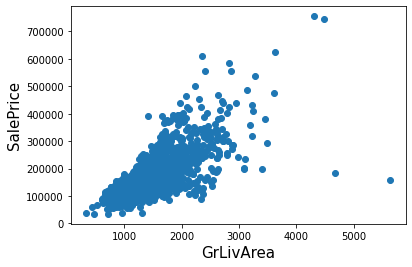

In [60]:
# log 변환하기 전 데이터에서 시각화
plt.scatter(x = house_df['GrLivArea'], y = house_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [62]:
# 조건 생성
cond1 = house_ohe['GrLivArea']>np.log1p(4000)
cond2 = house_ohe['SalePrice']<np.log1p(500000)
outlier_idx = house_ohe[cond1&cond2].index
# drop
house_ohe.drop(outlier_idx, axis=0, inplace=True)

### Evaluation(5) after feature engineering 2

In [63]:
y = house_ohe['SalePrice']
X = house_ohe.drop(columns=['SalePrice'], axis=1,inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=117)

ridge_parameter = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_parameter = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}
best_ridge = best_parameter(ridge, ridge_parameter)
best_lasso = best_parameter(lasso, lasso_parameter)

Ridge 5cv best avg RMSE: 0.1125, Best alpha: {'alpha': 8}
Lasso 5cv best avg RMSE: 0.1122, Best alpha: {'alpha': 0.001}


In [64]:
# re-fit with best parameters
lr_reg = LinearRegression()
ridge = Ridge(alpha=8)
lasso = Lasso(alpha=0.001)

lr_reg.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

def get_rmse(model):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return np.round(rmse,3)

for model in [lr_reg, ridge, lasso]:
    print('model:{}, rmsLe:{}'.format(model, get_rmse(model)))

model:LinearRegression(), rmsLe:0.113
model:Ridge(alpha=8), rmsLe:0.101
model:Lasso(alpha=0.001), rmsLe:0.1


- 오 쪼끔 더 좋아짐

### Model 변형 : 회귀 트리 이용

In [65]:
pip install xgboost

In [66]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': [1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate = 0.05,
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = best_parameter(xgb_reg, xgb_params)

XGBRegressor 5cv best avg RMSE: 0.1206, Best alpha: {'n_estimators': 1000}


In [68]:
pip install lightgbm

In [70]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimtors': [1000]}
lgb_reg = LGBMRegressor(n_estimators=1000, learning_rate = 0.05, num_leaves=4,
                        subsample=0.6, colsample_bytree=0.4)
best_lgbm = best_parameter(lgb_reg, lgbm_params)

  File "C:\Users\happy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Warning] Unknown parameter: n_estimtors
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_estimtors
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3157
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Unknown parameter: n_estimtors
[LightGBM] [Warning] Unknown parameter: n_estimtors
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_estimtors
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3169
[LightGBM] [Info] Number of data points i

In [74]:
# feature importances of XGBRegressor
xgb_reg.fit(X_train, y_train)
pd.Series(xgb_reg.feature_importances_, index = X.columns).sort_values(ascending= False).head(10)

OverallQual       0.103702
GarageCars        0.083339
CentralAir_N      0.080561
ExterQual_TA      0.063091
CentralAir_Y      0.050122
GarageQual_TA     0.034655
BsmtQual_Ex       0.034474
GarageCond_TA     0.032910
GrLivArea         0.021416
KitchenQual_TA    0.020546
dtype: float32

In [75]:
# feature importances of LGBMRegressor
lgb_reg.fit(X_train, y_train)
pd.Series(lgb_reg.feature_importances_, index = X.columns).sort_values(ascending= False).head(10)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3176
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 171
[LightGBM] [Info] Start training from score 12.021371


OverallQual    170
LotArea        157
TotalBsmtSF    138
GrLivArea      125
GarageYrBlt    116
YearBuilt      114
BsmtFinSF1     106
GarageArea     102
1stFlrSF       101
OverallCond     94
dtype: int32

### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

In [78]:
# 각 모델들의 예측 결과에 가중치를 주어서 최종 회귀 예측 결과 도출 

def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{} 모델의 RMSE: {}'.format(key, rmse))

ridge = Ridge(alpha=8)
lasso = Lasso(alpha=0.001)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

ridge_pred = ridge.predict(X_test)
lasso_pred = lasso.predict(X_test)

pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge' : ridge_pred,
         'Lasso' : lasso_pred}

get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.09912091443076262
Ridge 모델의 RMSE: 0.10102333763732314
Lasso 모델의 RMSE: 0.10031554333979276


In [79]:
xgb_reg.fit(X_train, y_train)
lgb_reg.fit(X_train, y_train)

xgb_pred = xgb_reg.predict(X_test)
lgb_pred = lgb_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.6 * lgb_pred
preds = {'최종 혼합': pred,
         'Ridge' : xgb_pred,
         'Lasso' : lgb_pred}

get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3176
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 171
[LightGBM] [Info] Start training from score 12.021371
최종 혼합 모델의 RMSE: 1.2022548088218037
Ridge 모델의 RMSE: 0.11528411449586126
Lasso 모델의 RMSE: 0.10818134939598639


### Stacking Model

- 회귀에서 스태킹 모델이 잘 (?) 먹히는 편이라고 한다..

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

